In [1]:
import pylidc as pl

In [2]:
ann = pl.query(pl.Annotation).first()
print(ann.scan.patient_id)

LIDC-IDRI-0078


In [3]:
# Query for all CT scans with desired traits.
scans = pl.query(pl.Scan).filter(pl.Scan.slice_thickness <= 1,
                                 pl.Scan.pixel_spacing <= 0.6)
print(scans.count())
# => 31

pid = 'LIDC-IDRI-0078'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

31


In [4]:
print(len(scan.annotations))

13


In [5]:
nods = scan.cluster_annotations()

print("%s has %d nodules." % (scan, len(nods)))
# => Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.

for i,nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))

Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.
Nodule 4 has 4 annotations.


In [6]:
vol = scan.to_volume()
print(vol.shape)
# => (512, 512, 87)

print("%.2f, %.2f" % (vol.mean(), vol.std()))

Loading dicom files ... This may take a moment.
(512, 512, 87)
-702.15, 812.52


Loading dicom files ... This may take a moment.


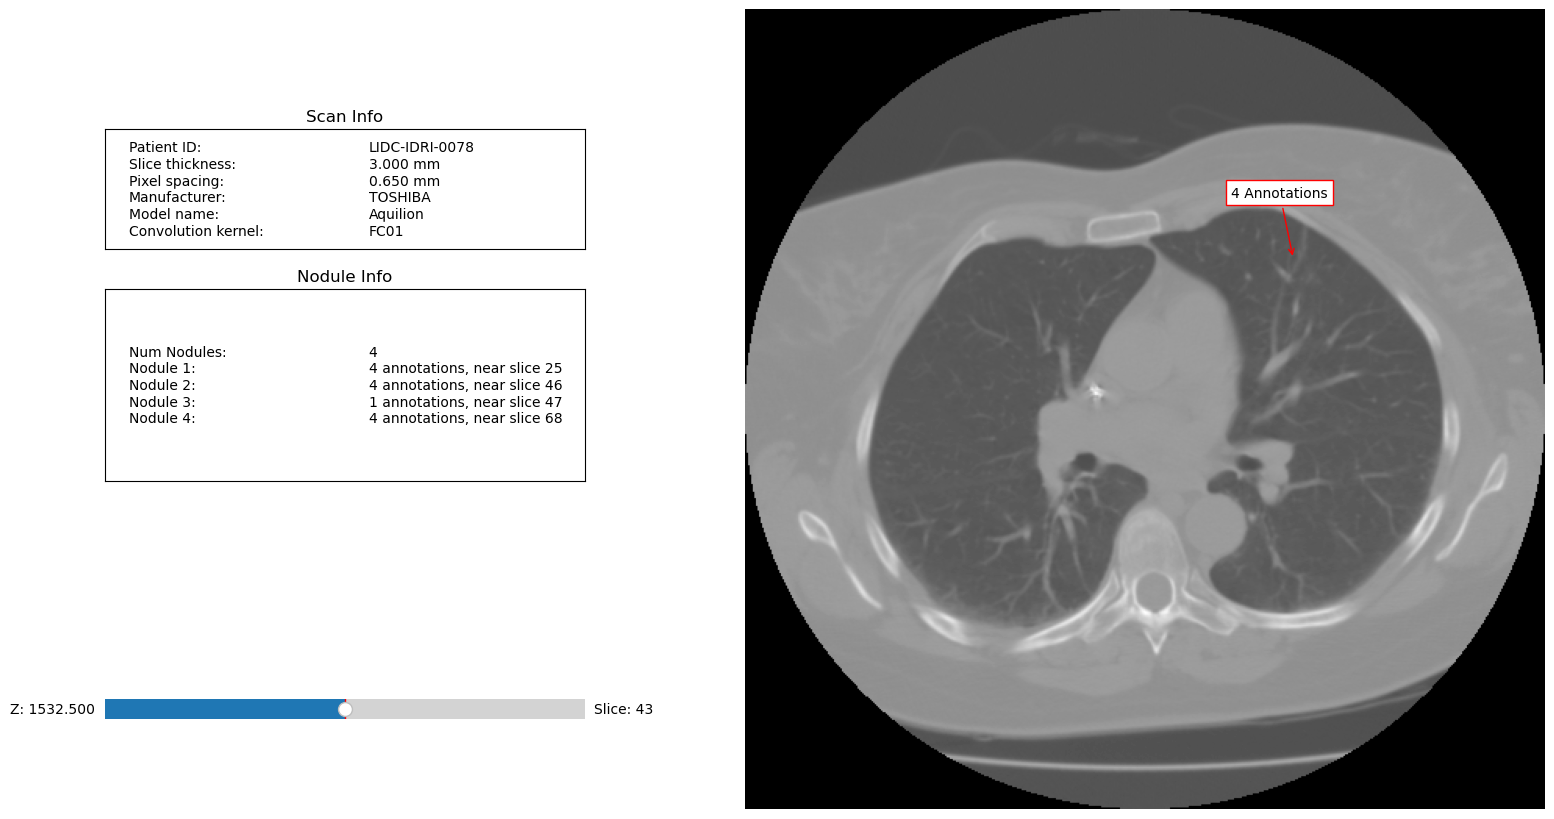

In [7]:
scan.visualize(annotation_groups=nods)

In [8]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy == 5).first()

print(ann.malignancy, ann.Malignancy)
# => 5, 'Highly Suspicious'

print(ann.margin, ann.Margin)
# => 2, 'Near Poorly Defined'

5 Highly Suspicious
2 Near Poorly Defined


In [9]:
ann.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid/Round              | 4 
Margin             | Near Poorly Defined      | 2 
Lobulation         | Near Marked Lobulation   | 4 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Highly Suspicious        | 5 


In [10]:
ann = pl.query(pl.Annotation).first()
contours = ann.contours

print(contours[0])
# => Contour(id=21,annotation_id=1)

Contour(id=1,annotation_id=1)


In [11]:
print("%.2f mm, %.2f mm^2, %.2f mm^3" % (ann.diameter,
                                         ann.surface_area,
                                         ann.volume))
# => 20.84 mm, 1242.74 mm^2, 2439.30 mm^3

20.84 mm, 1124.13 mm^2, 2439.30 mm^3


In [12]:
mask = ann.boolean_mask()
print(mask.shape, mask.dtype)
# => (34, 27, 6), dtype('bool')

(34, 27, 6) bool


In [13]:
bbox = ann.bbox()
print(bbox)
# => (slice(151, 185, None), slice(349, 376, None), slice(44, 50, None))

vol = ann.scan.to_volume()
print(vol[bbox].shape)
# => (34, 27, 6)

(slice(151, 185, None), slice(349, 376, None), slice(44, 50, None))
Loading dicom files ... This may take a moment.
(34, 27, 6)


In [14]:
print(ann.bbox_dims())
# => [21.45, 16.90, 15.0]

[21.45 16.9  15.  ]


Loading dicom files ... This may take a moment.


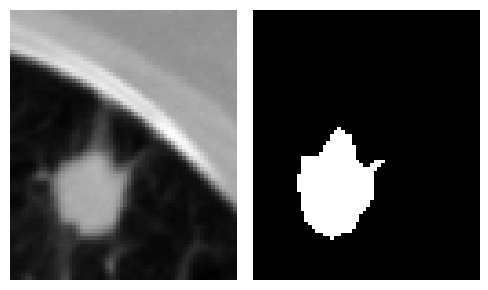

In [15]:
import pylidc as pl
import matplotlib.pyplot as plt

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()

padding = [(30,10), (10,25), (0,0)]

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(vol[bbox][:,:,2], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(mask[:,:,2], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

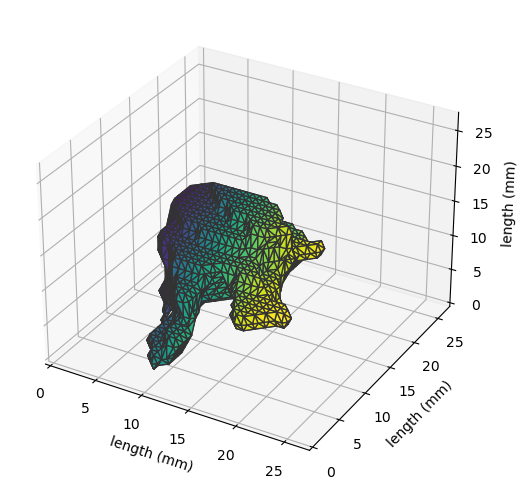

In [16]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.lobulation == 5).first()
ann.visualize_in_3d()

Loading dicom files ... This may take a moment.


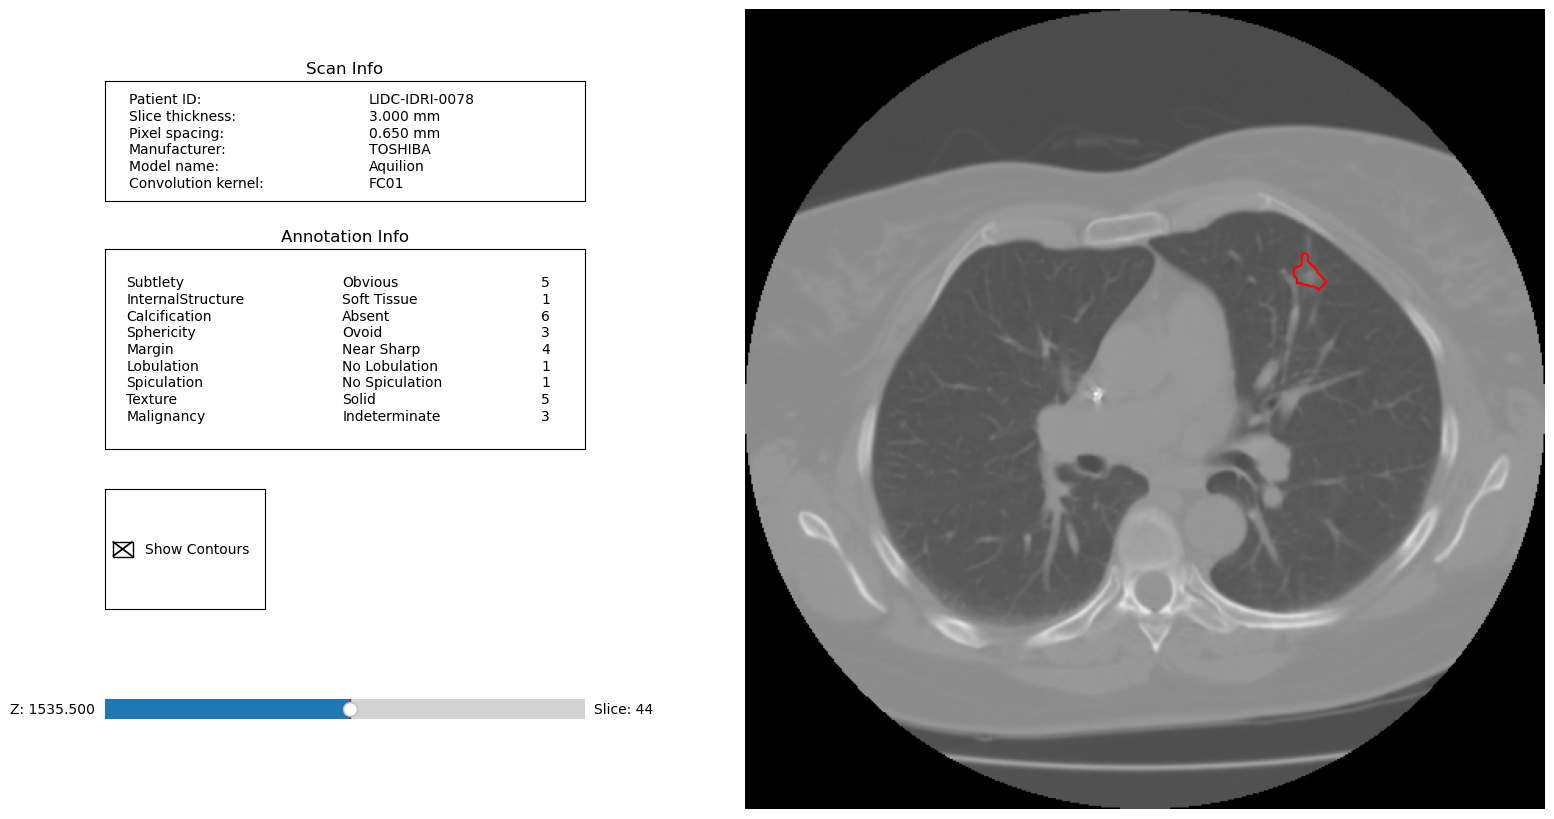

In [17]:
ann = pl.query(pl.Annotation).first()
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


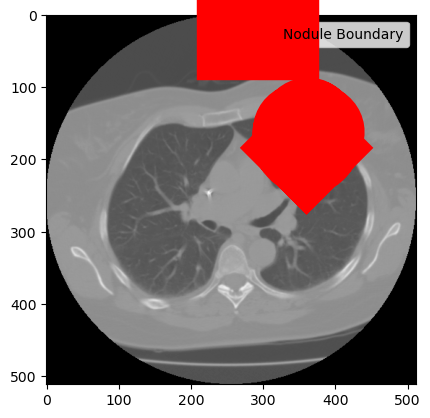

In [19]:
import pylidc as pl
import matplotlib.pyplot as plt

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()
con = ann.contours[3]

k = con.image_k_position
ii,jj = ann.contours[3].to_matrix(include_k=False).T

plt.imshow(vol[:,:,46], cmap=plt.cm.gray)
plt.plot(jj, ii, '-r', lw=68, label="Nodule Boundary")
plt.legend()
plt.show()

Loading dicom files ... This may take a moment.


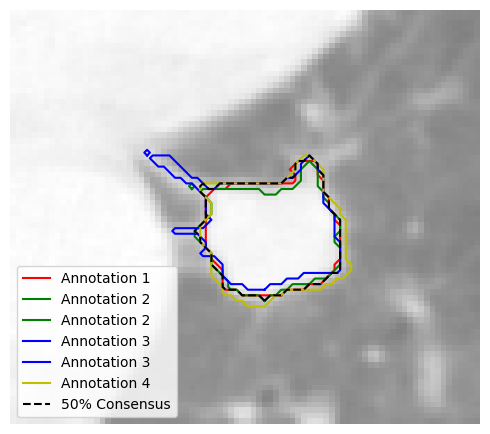

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from skimage.measure import find_contours

import pylidc as pl
from pylidc.utils import consensus


# Query for a scan, and convert it to an array volume.
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0078').first()
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[0]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
#plt.savefig("../images/consensus.png", bbox_inches="tight")
plt.show()